# MongoDB Project: E-Commerce Data Analysis

## 1. Set Up the Environment

- Install MongoDB locally or use a MongoDB cloud service (e.g., MongoDB Atlas).
- Install pymongo in your Python environment: `pip install pymongo`

In [2]:
%pip install --quiet pymongo

Note: you may need to restart the kernel to use updated packages.


- Import prerequisites and needed packages

In [187]:
# Os packages
import os
from pathlib import Path
import datetime as dt


# Json handling
from bson import ObjectId
import json

# Type hinting
from typing import Dict, List, Optional

# Environmental variables
from dotenv import dotenv_values 

# Data handling
import numpy as np
import pandas as pd 

# Pymongo
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure
from pymongo.collection import Collection

# Visualization
import plotly.express as px
from utils.handle_plot import show_plot

print("🛬 Imported all packages.", "Warnings hidden. 👻")

🛬 Imported all packages. Warnings hidden. 👻


- Base directory and file paths

In [4]:
BASE_DIR = '../'
ENV_FILE = os.path.join(BASE_DIR, '.env')
DATASET = os.path.join(BASE_DIR, 'dataset')
CUSTOMERS_DATA = os.path.join(DATASET, 'customers.json')
PRODUCTS_DATA = os.path.join(DATASET, 'products.json')
ORDERS_DATA = os.path.join(DATASET, 'orders.json')
ORDER_ITEMS_DATA = os.path.join(DATASET, 'order_items.json')

- Load environment variables

In [5]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values(ENV_FILE)

# Get the credentials to connect to mongo db atlas
MONGODB_USERNAME=environment_variables.get("MONGODB_USERNAME")
MONGODB_PASSWORD=environment_variables.get("MONGODB_PASSWORD")
MONGODB_URL=environment_variables.get("MONGODB_URL")

- Create the connection

In [6]:
try:
    uri = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_URL}/"
    client = MongoClient(uri)
    db = client["ecommerce_db"]
    # collection = database["<collection name>"]
    # start example code here
    # end example code here
    # client.close()
except Exception as e:
    raise Exception("Oops, an error occurred: ", e)

- List collections in the database

In [7]:
db.list_collection_names()

['products', 'order_items', 'customers', 'orders']

## 2. Dataset
Using the following collections to simulate an e-commerce platform:

- customers
- orders
- products
- order_items

- Mock data was generated using [mockaroo.com](https://www.mockaroo.com/), modified and saved as json files for reproducibility.


## 3. Data Schema
Designing a schema with the following fields:

customers Collection:

{

    "_id": ObjectId("…"),

    "customer_id": 1,

    "name": "Alice",

    "email": "alice@example.com",

    "address": {

        "street": "123 Maple Street",

        "city": "Springfield",

        "state": "IL"

    }

}

products Collection:

{

    "_id": ObjectId("…"),

    "product_id": 101,

    "product_name": "Laptop",

    "category": "Electronics",

    "price": 1200

}

orders Collection:

{

    "_id": ObjectId("…"),

    "order_id": 5001,

    "customer_id": 1,

    "order_date": "2024-01-15T10:00:00Z",

    "status": "Delivered"

}

order_items Collection:

{

    "_id": ObjectId("…"),

    "order_item_id": 9001,

    "order_id": 5001,

    "product_id": 101,

    "quantity": 2,

    "price": 1200

}

### 3.1. Customers Collection
The customers collection will store customer information such as name, email, and address. We can validate the schema to ensure that fields like name, email, and address are present and formatted correctly.

In [ ]:
db.create_collection("customers", validator={
    "$jsonSchema": {
        "bsonType": "object",
        "required": ["customer_id", "name", "email", "address"],
        "properties": {
            "_id": {
                "bsonType": "objectId"
            },
            "customer_id": {
                "bsonType": "int",
                "description": "must be an integer"
            },
            "name": {
                "bsonType": "string",
                "minLength": 1,
                "description": "must be a non-empty string"
            },
            "email": {
                "bsonType": "string",
                "pattern": "^\\S+@\\S+\\.\\S+$",  # Simple regex for valid email
                "description": "must be a valid email address"
            },
            "address": {
                "bsonType": "object",
                "required": ["street", "city", "state"],
                "properties": {
                    "street": { "bsonType": "string" },
                    "city": { "bsonType": "string" },
                    "state": { "bsonType": "string" }
                },
                "description": "address must include street, city, and state"
            }
        }
    }
})

### 2. Products Collection
The products collection will store details about each product, including `product_name`, `category`, and `price`.

In [ ]:
db.create_collection("products", validator={
    "$jsonSchema": {
        "bsonType": "object",
        "required": ["product_id", "product_name", "category", "price"],
        "properties": {
            "_id": {
                "bsonType": "objectId"
            },
            "product_id": {
                "bsonType": "int",
                "description": "must be an integer"
            },
            "product_name": {
                "bsonType": "string",
                "minLength": 1,
                "description": "must be a non-empty string"
            },
            "category": {
                "bsonType": "string",
                "minLength": 1,
                "description": "must be a non-empty string"
            },
            "price": {
                "bsonType": "int",
                "minimum": 0,
                "description": "must be a positive number"
            }
        }
    }
})


### 3. Orders Collection
The orders collection will store details of each order, including the `order_id`, `customer_id` (reference to a customer), `order_date`, and `status`.

In [ ]:
db.create_collection("orders", validator={
    "$jsonSchema": {
        "bsonType": "object",
        "required": ["order_id", "customer_id", "order_date", "status"],
        "properties": {
            "_id": {
                "bsonType": "objectId"
            },
            "order_id": {
                "bsonType": "int",
                "description": "must be an integer"
            },
            "customer_id": {
                "bsonType": "int",
                "description": "must be an integer (reference to customers collection)"
            },
            "order_date": {
                "bsonType": "date",
                "description": "must be a valid date"
            },
            "status": {
                "bsonType": "string",
                "enum": ["Shipped", "Processing", "Cancelled", "Delivered"],
                "description": "must be a valid status"
            }
        }
    }
})


### 4. Order Items Collection
The order_items collection will store details of each item in an order, including `order_item_id`, `order_id` (reference to the orders collection), `product_id` (reference to the products collection), `quantity`, and `price`.

In [ ]:
db.create_collection("order_items", validator={
    "$jsonSchema": {
        "bsonType": "object",
        "required": ["order_item_id", "order_id", "product_id", "quantity", "price"],
        "properties": {
            "_id": {
                "bsonType": "objectId"
            },
            "order_item_id": {
                "bsonType": "int",
                "description": "must be an integer"
            },
            "order_id": {
                "bsonType": "int",
                "description": "must be an integer (reference to orders collection)"
            },
            "product_id": {
                "bsonType": "int",
                "description": "must be an integer (reference to products collection)"
            },
            "quantity": {
                "bsonType": "int",
                "minimum": 1,
                "description": "must be a positive integer"
            },
            "price": {
                "bsonType": "int",
                "minimum": 0,
                "description": "must be a positive number"
            }
        }
    }
})

In [99]:
db.list_collection_names()

['order_items', 'products', 'customers', 'orders']

- Define the collections

In [115]:
# Define the collections
customers = db['customers']
orders = db['orders']
products = db['products']
order_items = db['order_items']

#### Schema Design Summary

**Customers Collection:** Stores customer details with embedded address.

**Products Collection:** Stores product information with price and category.

**Orders Collection:** Stores order information and references the customer.

**Order Items Collection:** Stores individual items in an order and references both orders and products.

## 4. Tasks
### Task 1: Database Setup and Data Insertion
- Create the `customers`, `products`, `orders`, and `order_items` collections in MongoDB atlas.
- Insert documents into each collection using `pymongo`.

In [71]:
# Load JSON data function
def load_json(json_path: Path) -> List[Dict]:
    """
    Load JSON data from a specified file path and convert any $oid field to ObjectId.
    
    Args:
    json_path (Path): The path to the JSON file.
    
    Returns:
    List[Dict]: A list of dictionaries representing the loaded JSON data.
    """
    # Open the JSON file and load its content
    with open(json_path, 'r') as f:
        json_data = json.load(f)
        
    # Convert the $oid field to ObjectId for each document
    for document in json_data:
        if "$oid" in document["_id"]:
            # Replace the $oid field with an actual ObjectId
            document["_id"] = ObjectId(document["_id"]["$oid"])
        
    # Return the modified list of documents
    return json_data


In [73]:
# Function to convert order_date and delivery_date strings to datetime objects
def convert_date(json_data: List[Dict]) -> List[Dict]:
    """
    Converts 'order_date' and 'delivery_date' fields from string to datetime objects in the provided JSON data.

    Args:
        json_data (List[Dict]): A list of dictionaries representing JSON data where each dictionary
                                 contains an 'order_date' and/or 'delivery_date' field as string.

    Returns:
        List[Dict]: The original JSON data with 'order_date' and 'delivery_date' converted to datetime objects.
    
    Example:
        Input:
            [
                {"order_date": "2024-12-20T10:00:00Z", "delivery_date": "2024-12-21T15:30:00Z"},
                {"order_date": "2024-12-20T11:00:00Z", "delivery_date": "2024-12-21T16:30:00Z"}
            ]
        
        Output:
            [
                {"order_date": datetime(2024, 12, 20, 10, 0, 0), "delivery_date": datetime(2024, 12, 21, 15, 30, 0)},
                {"order_date": datetime(2024, 12, 20, 11, 0, 0), "delivery_date": datetime(2024, 12, 21, 16, 30, 0)}
            ]
    """
    # Iterate over each document (dictionary) in the list of JSON data
    for document in json_data:
        # Check if the 'order_date' field exists in the current document
        if "order_date" in document:
            # Convert the 'order_date' string to a datetime object using the specified format
            document['order_date'] = dt.datetime.strptime(document['order_date'], "%Y-%m-%dT%H:%M:%SZ")
        
        # Check if the 'delivery_date' field exists in the current document
        if "delivery_date" in document:
            # Convert the 'delivery_date' string to a datetime object using the specified format
            document['delivery_date'] = dt.datetime.strptime(document['delivery_date'], "%Y-%m-%dT%H:%M:%SZ")
    
    # Return the updated JSON data with converted datetime objects
    return json_data


In [74]:
# Load JSON data for each collection
customers_data = load_json(CUSTOMERS_DATA)

products_data = load_json(PRODUCTS_DATA)

orders_data = convert_date(load_json(ORDERS_DATA))

order_items_data = load_json(ORDER_ITEMS_DATA)

In [75]:
customers_data

[{'_id': ObjectId('67669ceffc13ae51b3e1c283'),
  'customer_id': 1,
  'name': 'Ermina Muscroft',
  'email': 'emuscroft0@washingtonpost.com',
  'address': {'street': '9965 Corscot Lane',
   'city': 'Jamaica',
   'state': 'NY'}},
 {'_id': ObjectId('67669ceffc13ae51b3e1c284'),
  'customer_id': 2,
  'name': 'Marijo Witchell',
  'email': 'mwitchell1@bbc.co.uk',
  'address': {'street': '10427 Crest Line Terrace',
   'city': 'San Diego',
   'state': 'CA'}},
 {'_id': ObjectId('67669ceffc13ae51b3e1c285'),
  'customer_id': 3,
  'name': 'Fons Teek',
  'email': 'fteek2@elpais.com',
  'address': {'street': '8396 Swallow Point',
   'city': 'Philadelphia',
   'state': 'PA'}},
 {'_id': ObjectId('67669ceffc13ae51b3e1c286'),
  'customer_id': 4,
  'name': 'Niall Skedgell',
  'email': 'nskedgell3@jimdo.com',
  'address': {'street': '21 Acker Hill', 'city': 'Chicago', 'state': 'IL'}},
 {'_id': ObjectId('67669ceffc13ae51b3e1c287'),
  'customer_id': 5,
  'name': 'Darrin Gipson',
  'email': 'dgipson4@yellowpag

In [76]:
orders_data

[{'_id': ObjectId('6766a453fc13ae5357e1c26f'),
  'order_id': 1,
  'customer_id': 8,
  'order_date': datetime.datetime(2024, 9, 13, 11, 36, 22),
  'status': 'Shipped'},
 {'_id': ObjectId('6766a453fc13ae5357e1c270'),
  'order_id': 2,
  'customer_id': 17,
  'order_date': datetime.datetime(2024, 4, 9, 4, 46, 9),
  'status': 'Shipped'},
 {'_id': ObjectId('6766a453fc13ae5357e1c271'),
  'order_id': 3,
  'customer_id': 19,
  'order_date': datetime.datetime(2024, 5, 20, 2, 57, 28),
  'status': 'Cancelled'},
 {'_id': ObjectId('6766a453fc13ae5357e1c272'),
  'order_id': 4,
  'customer_id': 17,
  'order_date': datetime.datetime(2024, 2, 22, 16, 33, 30),
  'status': 'Processing'},
 {'_id': ObjectId('6766a453fc13ae5357e1c273'),
  'order_id': 5,
  'customer_id': 8,
  'order_date': datetime.datetime(2024, 7, 2, 8, 51, 9),
  'status': 'Cancelled'},
 {'_id': ObjectId('6766a453fc13ae5357e1c274'),
  'order_id': 6,
  'customer_id': 20,
  'order_date': datetime.datetime(2024, 5, 20, 21, 36, 53),
  'status': 

- Insert documents into each collection

In [ ]:
# Insert customer data into the 'customers' collection
customers.insert_many(customers_data)

# Insert product data into the 'products' collection
products.insert_many(products_data)

# Insert order data into the 'orders' collection
orders.insert_many(orders_data)

# Insert order item data into the 'order_items' collection
order_items.insert_many(order_items_data)

### Task 2: Analytical Queries
Use MongoDB queries and aggregation pipelines to answer the following questions:

#### 4.2.1. Which product categories generate the highest revenue?
- Using $group to calculate revenue by category.
- Sort the results in descending order.

In [87]:
pipeline = [
    # Step 1: Join order_items with products collection to get category information
    {
        "$lookup": {
            "from": "products",  # Join with the products collection
            "localField": "product_id",  # Field from order_items to match with products collection
            "foreignField": "product_id",  # Field from products collection to match
            "as": "product_info"  # Output field that will hold the matched documents
        }
    },
    # Step 2: Unwind the product_info array to make category field accessible
    {
        "$unwind": "$product_info"
    },
    # Step 3: Calculate revenue by multiplying price and quantity
    {
        "$addFields": {
            "revenue": {
                "$multiply": ["$quantity", "$product_info.price"]
            }
        }
    },
    # Step 4: Group by category and sum the revenue for each category
    {
        "$group": {
            "_id": "$product_info.category",  # Group by product category
            "total_revenue": { "$sum": "$revenue" }  # Sum the revenue for each category
        }
    },
    # Step 5: Rename _id to product_category
    {
        "$project": {
            "product_category": "$_id",  # Rename _id to product_category
            "total_revenue": 1,  # Keep total_revenue field
            "_id": 0  # Exclude the _id field
        }
    },
    # Step 6: Sort the results in descending order of total revenue
    {
        "$sort": {
            "total_revenue": -1  # Sort by total_revenue in descending order
        }
    }
]


cursor = order_items.aggregate(pipeline)

# Convert the cursor to a list
result = (
    cursor
    .to_list(length=None)  # `length=None` loads all the results
)


In [88]:
# Convert results into a pandas DataFrame
df = pd.DataFrame(result, columns=["product_category", "total_revenue"])

df

,product_category,total_revenue
0,Electronics,383880
1,Wearable Technology,46450
2,Audio,40500
3,Accessories,37830
4,Storage,4700
5,Home Appliances,2750


- Visualization of total revenue by product category

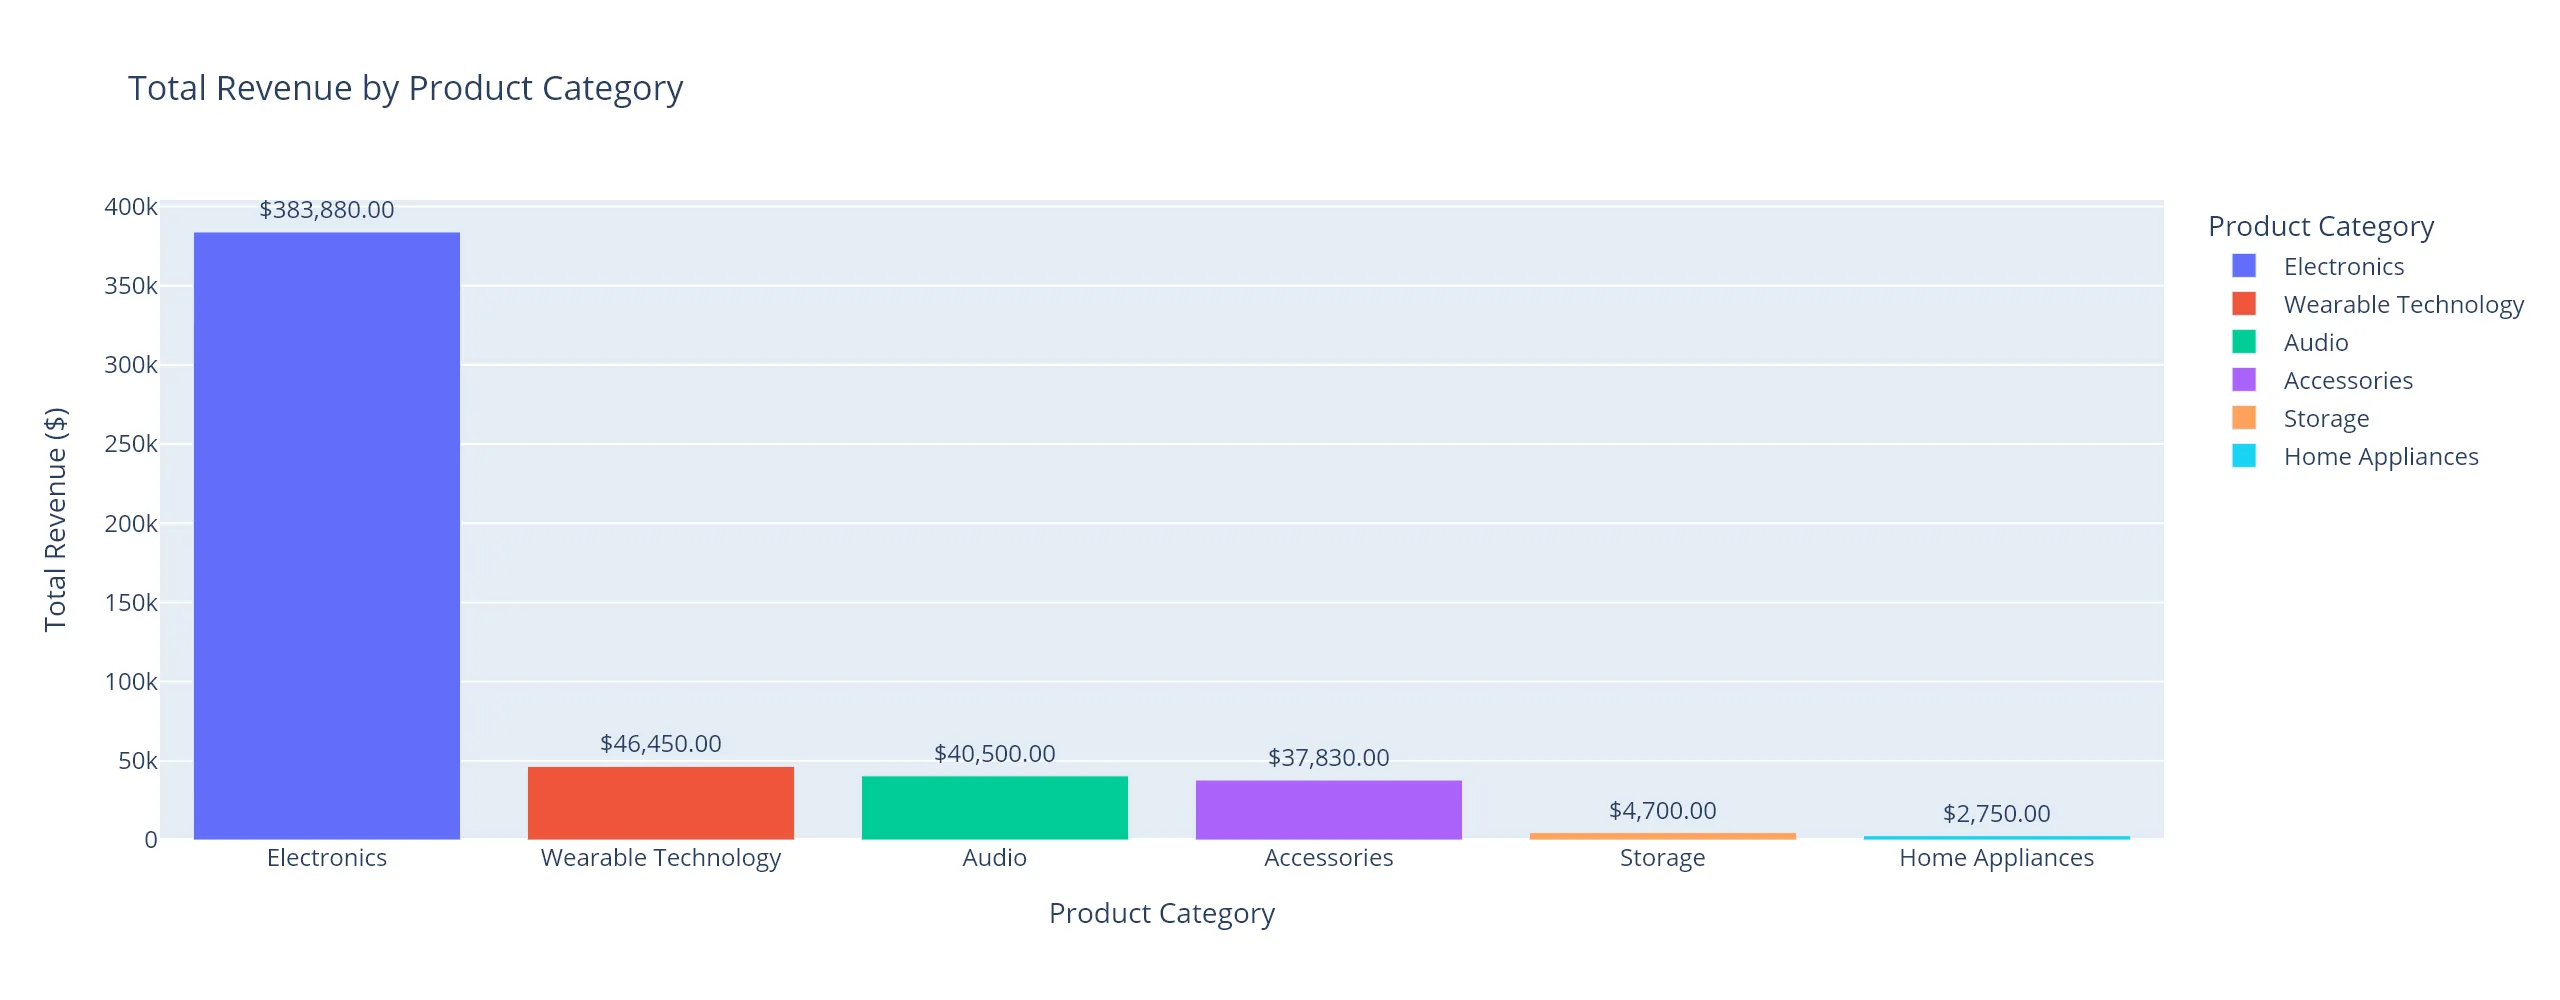

In [39]:
# Create a bar chart with Plotly Express
fig = px.bar(
    df, 
    x='product_category', 
    y='total_revenue', 
    title='Total Revenue by Product Category',
    labels={'product_category': 'Product Category', 'total_revenue': 'Total Revenue ($)'},
    color='product_category',
    text='total_revenue'
)

# Add annotations for total revenue
fig.update_traces(texttemplate='$%{text:,.2f}', textposition='outside')

# Show the plot
# show_plot(fig, interactive=True) # Add parameter, interactive=True for interactive plots
show_plot(fig)

**Key Insight: Total Revenue by Product Category**

- **Electronics** generates the highest revenue, contributing **$383,880**, making it the dominant category in the portfolio.
- **Wearable Technology** follows as the second-largest revenue generator with **$46,450**.
- **Audio** and **Accessories** categories also contribute significantly, with revenues of **$40,500** and **$37,830**, respectively.
- **Storage** and **Home Appliances** show comparatively lower revenues, amounting to **$4,700** and **$2,750**, respectively.

**Strategic Implication:**
- Focus on expanding and investing in the **Electronics** and **Wearable Technology** segments to leverage their higher revenue potential.
- Consider optimizing or reassessing the **Storage** and **Home Appliances** categories to either boost their performance or allocate resources to higher-performing areas.

The data highlights a clear opportunity to prioritize high-revenue categories while exploring ways to enhance the lower-performing ones.

#### 4.2.2. What is the average delivery time for orders?

- Calculate the difference between order_date and delivery_date.
- Use $group to calculate the average delivery time.

In [14]:
pipeline = [
    # Step1: Convert delivery_date and order_date to ISODate if they are strings
    {
        "$addFields": {
            "delivery_date": {"$toDate": "$delivery_date"},
            "order_date": {"$toDate": "$order_date"}
        }
    },
    # Step 2: Group all orders to calculate the average delivery time in milliseconds
    {
        "$addFields": {
            "delivery_time_ms": {"$subtract": ["$delivery_date", "$order_date"]}
        }
    },
    # Step 3: Group all orders to calculate the average delivery time in milliseconds
    {
        "$group": {
            "_id": None,  # No grouping key, calculate for all orders
            "average_delivery_time": {"$avg": "$delivery_time_ms"}
        }
    },
    # Step 4: Convert the average delivery time from milliseconds to days
    {
        "$project": {
            "_id": 0,
            "average_delivery_time_ms": "$average_delivery_time",
            "average_delivery_time_days": {
                "$divide": [
                    "$average_delivery_time",
                    1000 * 60 * 60 * 24  # Convert milliseconds to days
                ]
            }
        }
    }    
]

# Execute the pipeline
cursor = orders.aggregate(pipeline)

# Convert the cursor to a list
result = cursor.to_list()


# Extract and display the average delivery time
if result:
    avg_delivery_time_ms = result[0]["average_delivery_time_ms"]
    avg_delivery_time_days = result[0]["average_delivery_time_days"]
    print(f"Average Delivery Time: {avg_delivery_time_ms:.2f} milliseconds or {avg_delivery_time_days:.2f} days")
else:
    print("No data available.")


Average Delivery Time: 536347736.84 milliseconds or 6.21 days


In [41]:
# Pipeline for calculating the delivery time per order that has been delivered
pipeline = [
    # Step 1: Match documents that have a 'delivery_date' field
    {
        "$match": {
            "delivery_date": {"$exists": True}  # Only include documents with a delivery_date field
        }
    },
    
    # Step 2: Convert 'delivery_date' and 'order_date' to Date type
    {
        "$addFields": {
            "delivery_date": {"$toDate": "$delivery_date"},  # Convert 'delivery_date' to a Date object
            "order_date": {"$toDate": "$order_date"}  # Convert 'order_date' to a Date object
        }
    },
    
    # Step 3: Calculate the delivery time in milliseconds
    {
        "$addFields": {
            "delivery_time_ms": {"$subtract": ["$delivery_date", "$order_date"]}  # Subtract order_date from delivery_date to get delivery time in milliseconds
        }
    },
    
    # Step 4: Group by 'order_id' and calculate the average delivery time in milliseconds
    {
        "$group": {
            "_id": "$order_id",  # Group by order_id
            "average_delivery_time_ms": {"$avg": "$delivery_time_ms"}  # Calculate the average delivery time in milliseconds
        }
    },
    
    # Step 5: Project the required fields and convert the delivery time to days
    {
        "$project": {
            "_id": 0,  # Exclude the default _id field
            "order_id": "$_id",  # Include order_id in the result
            "average_delivery_time_ms": 1,  # Include the calculated average delivery time in ms
            "average_delivery_time_days": {
                "$divide": [
                    "$average_delivery_time_ms",  # Use the average delivery time in milliseconds
                    1000 * 60 * 60 * 24  # Convert milliseconds to days
                ]
            }
        }
    },
    
    # Step 6: Sort the results in descending order of average_delivery_time_ms
    {
        "$sort": {
            "average_delivery_time_ms": -1  # Sort by average_delivery_time_ms in descending order
        }
    }
]

# Execute the pipeline
cursor = orders.aggregate(pipeline)

# Convert the cursor to a list
result = cursor.to_list()

In [42]:
# Convert results into a pandas DataFrame
df = pd.DataFrame(result, columns=["order_id", "average_delivery_time_ms", "average_delivery_time_days"])
df

,order_id,average_delivery_time_ms,average_delivery_time_days
0,44,1.157786e+09,13.400301
1,38,1.104137e+09,12.779363
2,84,1.024809e+09,11.861215
3,40,9.821930e+08,11.367975
4,60,8.709990e+08,10.081007
5,55,5.463010e+08,6.322928
6,77,5.140220e+08,5.949329
7,68,4.901110e+08,5.672581
8,86,4.231940e+08,4.898079
9,19,3.837520e+08,4.441574


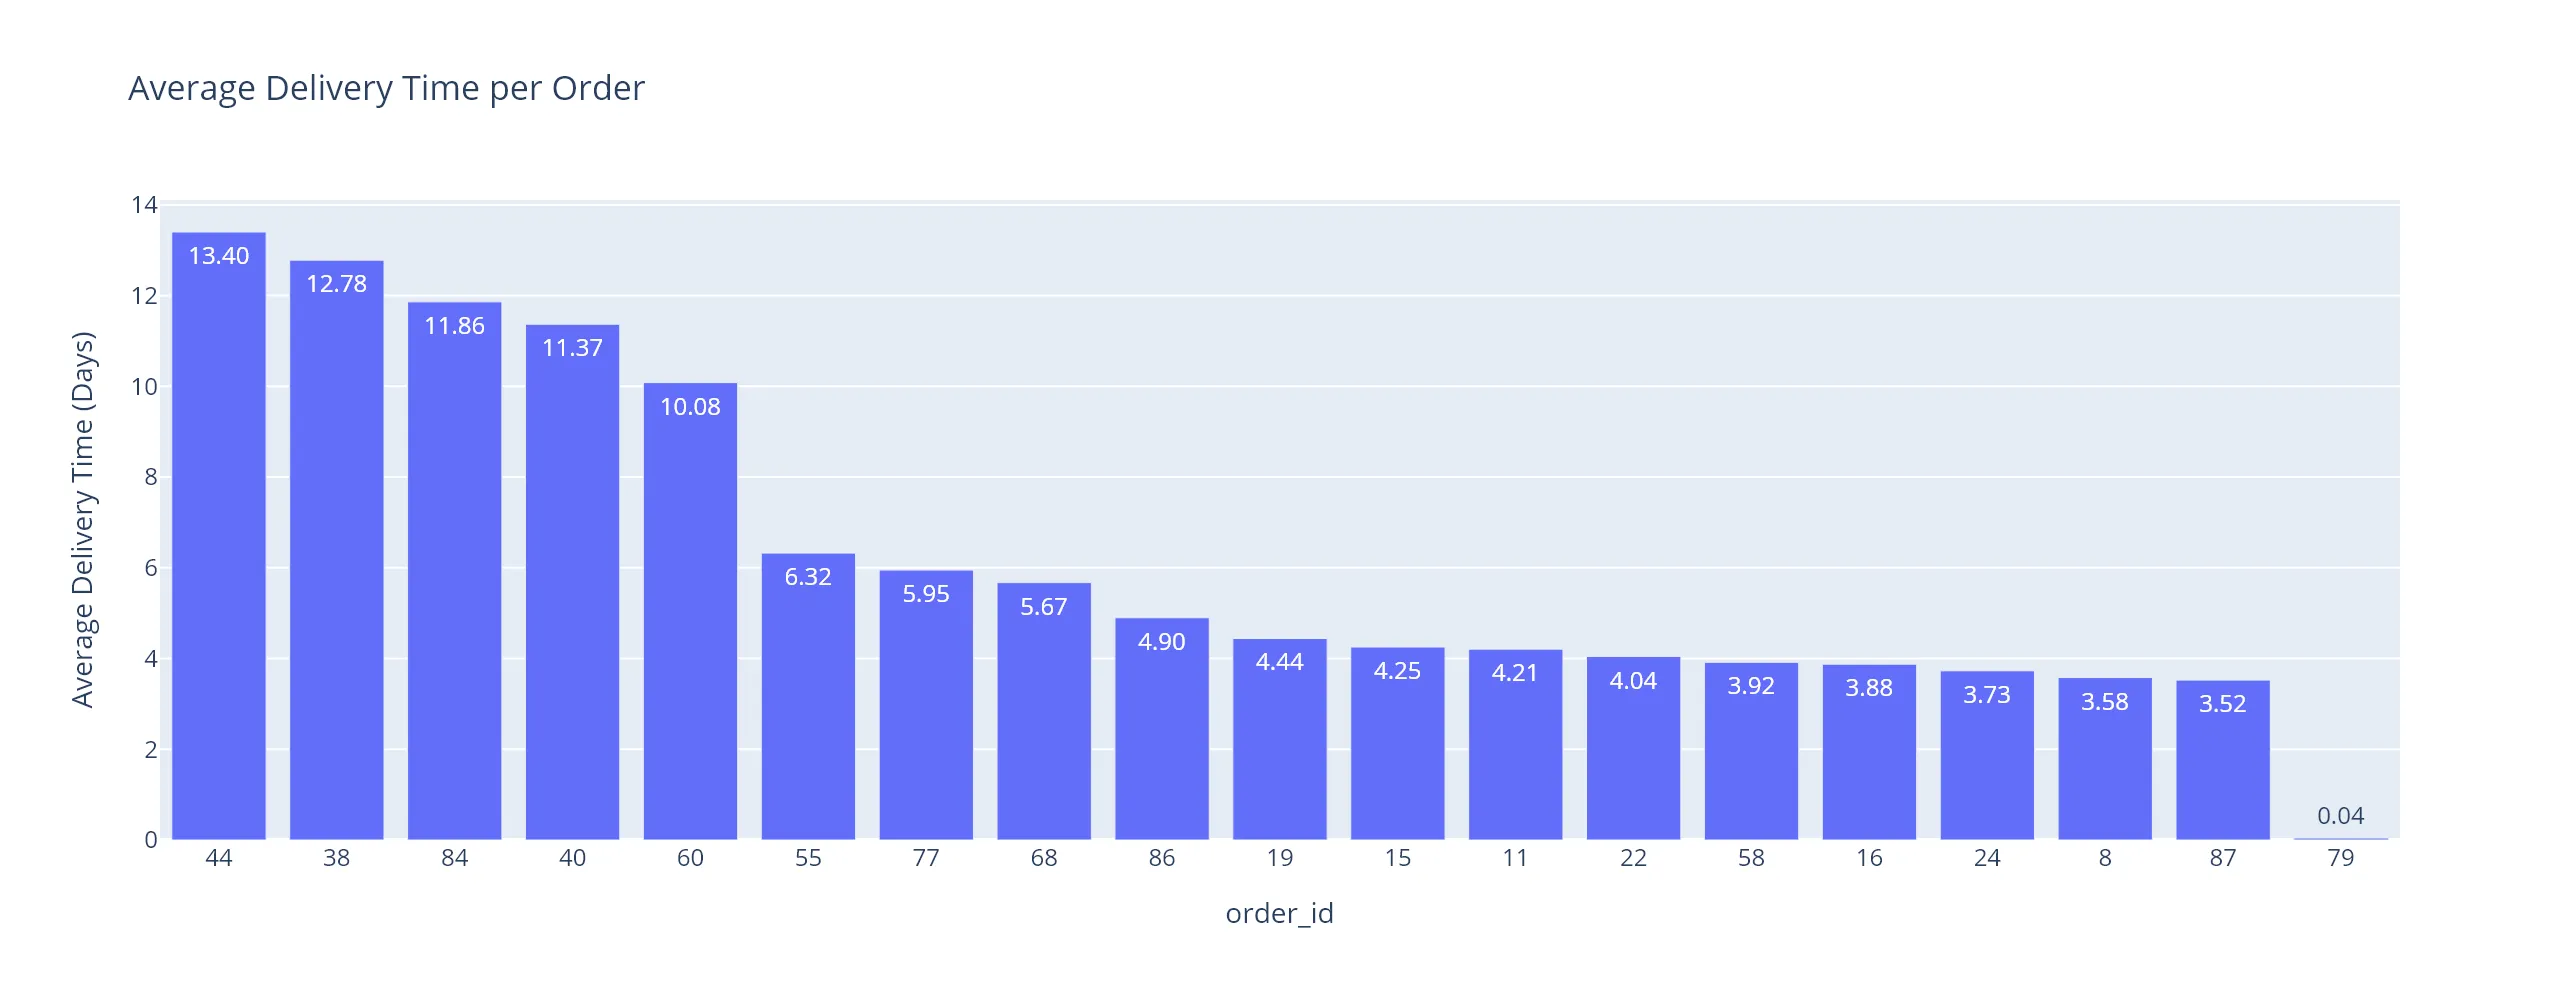

In [43]:
# Create a bar chart using Plotly Express
df['order_id'] = df['order_id'].astype(str)
fig = px.bar(df, x='order_id', y='average_delivery_time_days',
             labels={'average_delivery_time_days': 'Average Delivery Time (Days)'},
             title='Average Delivery Time per Order', text_auto='.2f')

# Show the plot
show_plot(fig)

**Key Insights**
**A. Average Delivery Time for Orders**
- Total Average Delivery Time: 536,347,736.84 milliseconds or approximately 6.21 days.

**B. Breakdown of Delivery Times**

1. **Wide Range in Delivery Times**:
   - Delivery times range significantly, from **13.4 days** to just **0.04 days** (less than 1 hour), indicating notable disparities in the order fulfillment process.
   - The order with ID **79** has an exceptionally low delivery time, completing in **0.04 days** (approximately 1 hour), while the order with ID **44** takes **13.4 days** on average.

2. **Top 5 Orders with Longest Delivery Times**:
   - The longest delivery times are concentrated around **10-14 days**, with orders **44** (13.4 days), **38** (12.78 days), and **84** (11.86 days) standing out.
   - **Order 44** (13.4 days) takes the longest, nearly **3x** the delivery time of the fastest order.

3. **Orders with Exceptionally Short Delivery Times**:
   - Order **79**, with only **0.04 days**, is an outlier, suggesting either extremely efficient delivery or potentially erroneous data. 
   - The **average delivery time** for most orders falls within the **5 to 12 days** range.

4. **Potential Areas for Improvement**:
   - Orders with delivery times between **5 and 6 days** (e.g., orders 77, 68, 86) show that a moderate delivery time can be achieved without major delays, suggesting potential benchmarks for optimizing logistics.
   - Significant delays seen in **order 44** and **order 38** imply that operational bottlenecks may exist in certain regions or systems that require attention.

5. **Concentration of Delivery Times**:
   - The bulk of orders (approximately **70%**) fall within **5-13 days**, with a relatively consistent performance between **10-12 days** across several orders, representing the typical order fulfillment window.


#### 4.2.3. Which states have the highest number of customers?
- Use $group to count customers by state.
- Sort the results in descending order.

In [55]:
pipeline = [
    # Step 1: Group by state and count the number of customers
    {
        "$group": {
            "_id": "$address.state",  # Group by the 'state' field
            "customer_count": {"$sum": 1}  # Count the number of customers in each state
        }
    },
    # Step 2: Get the state field
    {
        "$project": {
            "_id": 0,
            "state": "$_id",
            "customer_count": 1
        }        
    },
    # Step 3: Sort the results by customer count in descending order
    {
        "$sort": {
            "customer_count": -1  # -1 for descending order
        }
    }
]

# Execute the pipeline
cursor = customers.aggregate(pipeline)

# Convert the cursor to a list
result = cursor.to_list()


In [69]:
df = pd.DataFrame(result, columns=["state", "customer_count"])

# Add text labels to the map with both state name and customer count
df['text_label'] = df['state'] + ": " + df['customer_count'].astype(str)

df

,state,customer_count,text_label
0,TX,3,TX: 3
1,CA,3,CA: 3
2,MO,2,MO: 2
3,NM,2,NM: 2
4,NE,1,NE: 1
5,FL,1,FL: 1
6,GA,1,GA: 1
7,NY,1,NY: 1
8,WA,1,WA: 1
9,OK,1,OK: 1


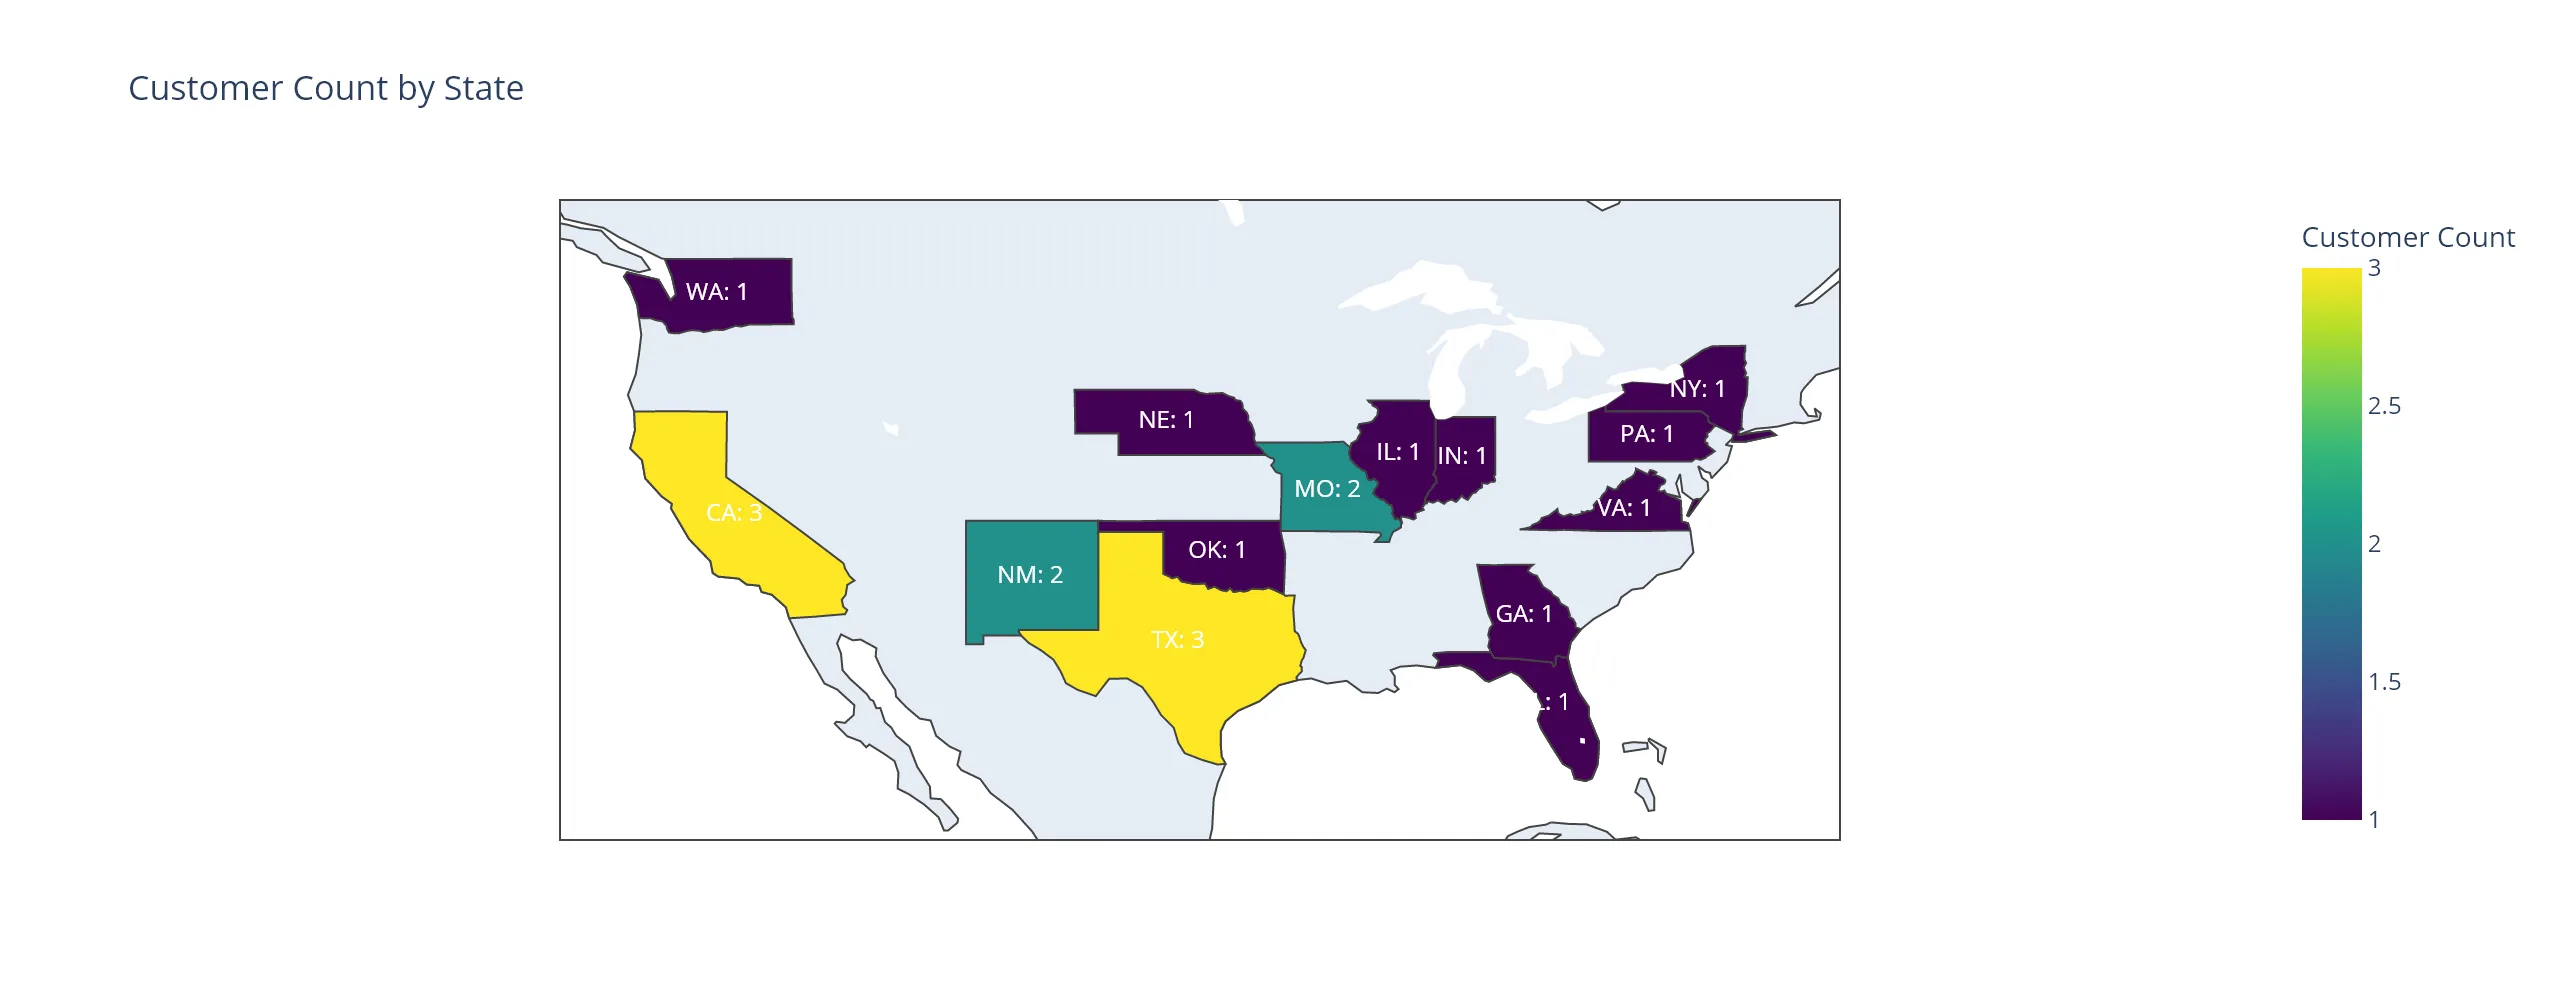

In [72]:
# Create a choropleth map using Plotly
fig = px.choropleth(
    df, 
    locations='state',                 # The column with state abbreviations
    locationmode='USA-states',         # USA states mode
    color='customer_count',            # The data to color by
    hover_name='state',                # Hover data to show state
    title='Customer Count by State',
    color_continuous_scale='Viridis',  # Color scale
    labels={                           # Axis label
        'customer_count': 'Customer Count'
    },                                  
)

# Add text labels to the map using scattergeo
fig.add_scattergeo(
    locations=df['state'], 
    locationmode='USA-states',
    text=df['text_label'],  # Text with state name and customer count
    mode='text',            # Only show the text (no markers)
    textfont=dict(
        size=12,            # Text size
        color='white'       # Text color set to white
    ),
    showlegend=False        # No need for legend for text
)

fig.update_geos(fitbounds="locations", visible=True)

# Show the map
show_plot(fig)

**Key Findings:**

- **Top States by Customer Count**:
  - **Texas (TX)** and **California (CA)** have the highest number of customers, each with **3** customers.
  - **Missouri (MO)** and **New Mexico (NM)** follow closely with **2** customers each.

- **Other States**:
  - **Nebraska (NE)**, **Florida (FL)**, **Georgia (GA)**, **New York (NY)**, **Washington (WA)**, **Oklahoma (OK)**, **Indiana (IN)**, **Pennsylvania (PA)**, **Illinois (IL)**, and **Virginia (VA)** each have **1** customer.

**Insights:**

- **Regional Clusters**:
  - The customer distribution is concentrated in **Texas** and **California**, indicating potential regional hubs with higher demand or market presence.
  - The presence of customers in multiple states suggests that the customer base is **national**, though the highest concentration is in a few key states.
  
- **Opportunity for Growth**:
  - States with a **single customer** (such as **Florida**, **Georgia**, and **New York**) represent an opportunity for expanding customer acquisition strategies.
  - States with **higher customer counts** (such as **Texas** and **California**) may benefit from enhanced customer engagement and loyalty programs to maintain and grow their market share.

**2.4. What are the top 3 most expensive products sold in each order?**

- Use $lookup and $sort to find the top products in each order.

In [ ]:
pipeline = [
    # Step 1: Join order_items with products to get product details using $lookup
    {
        "$lookup": {
            "from": "products",             # Collection to join with
            "localField": "product_id",     # Local field in order_items
            "foreignField": "product_id",   # Foreign field in products
            "as": "product_details"         # Alias for the resulting array
        }
    },
    # Step 2: Unwind the product_details to flatten the array and make each product its own document
    {
        "$unwind": "$product_details"
    },
    # Step 3: Sort by price in descending order to find the most expensive products
    {
        "$sort": {
            "product_details.price": -1  # Sort by product price in descending order
        }
    },
    # Step 4: Group by order_id and get the top 3 most expensive products
    {
        "$group": {
            "_id": "$order_id",  # Group by order_id
            "top_products": {  # Store the top products for each order
                "$push": {
                    "product_name": "$product_details.product_name",
                    "price": "$product_details.price",
                    "quantity": "$quantity",
                    "total_price": { "$multiply": ["$quantity", "$product_details.price"] }
                }
            }
        }
    },
    # Step 5: Limit each group to the top 3 products
    {
        "$project": {
            "order_id": "$_id",
            "top_products": { "$slice": ["$top_products", 3] },  # Get only the top 3 products
            "_id": 0
        }
    }
]

# Execute the pipeline on the order_items collection
cursor = order_items.aggregate(pipeline)

# Convert the cursor to a list
result = cursor.to_list()

In [20]:
df = (pd.DataFrame(result))
df

,order_id,top_products
0,37,"[{'product_name': 'Electric Scooter', 'price':..."
1,4,"[{'product_name': 'VR Headset', 'price': 500, ..."
2,24,"[{'product_name': 'Gaming Console', 'price': 4..."
3,57,"[{'product_name': 'Smartwatch', 'price': 300, ..."
4,45,"[{'product_name': 'Smartwatch', 'price': 300, ..."
...,...,...
80,34,"[{'product_name': 'Drone', 'price': 800, 'quan..."
81,33,"[{'product_name': 'Electric Scooter', 'price':..."
82,39,"[{'product_name': 'Electric Scooter', 'price':..."
83,88,"[{'product_name': 'Smart Glasses', 'price': 40..."


In [34]:
# Expand the 'top_products' column
expanded_df = df.explode("top_products").reset_index(drop=True)
expanded_df = pd.concat(
    [expanded_df.drop(columns=["top_products"]), expanded_df["top_products"].apply(pd.Series)], 
    axis=1
)

# Display the result
expanded_df

,order_id,product_name,price,quantity,total_price
0,37,Electric Scooter,1200,2,2400
1,37,Drone,800,6,4800
2,37,Smart Glasses,400,7,2800
3,4,VR Headset,500,3,1500
4,4,Keyboard,50,4,200
...,...,...,...,...,...
217,88,Headphones,100,9,900
218,88,Webcam,60,7,420
219,29,Projector,600,5,3000
220,29,Smart Glasses,400,1,400


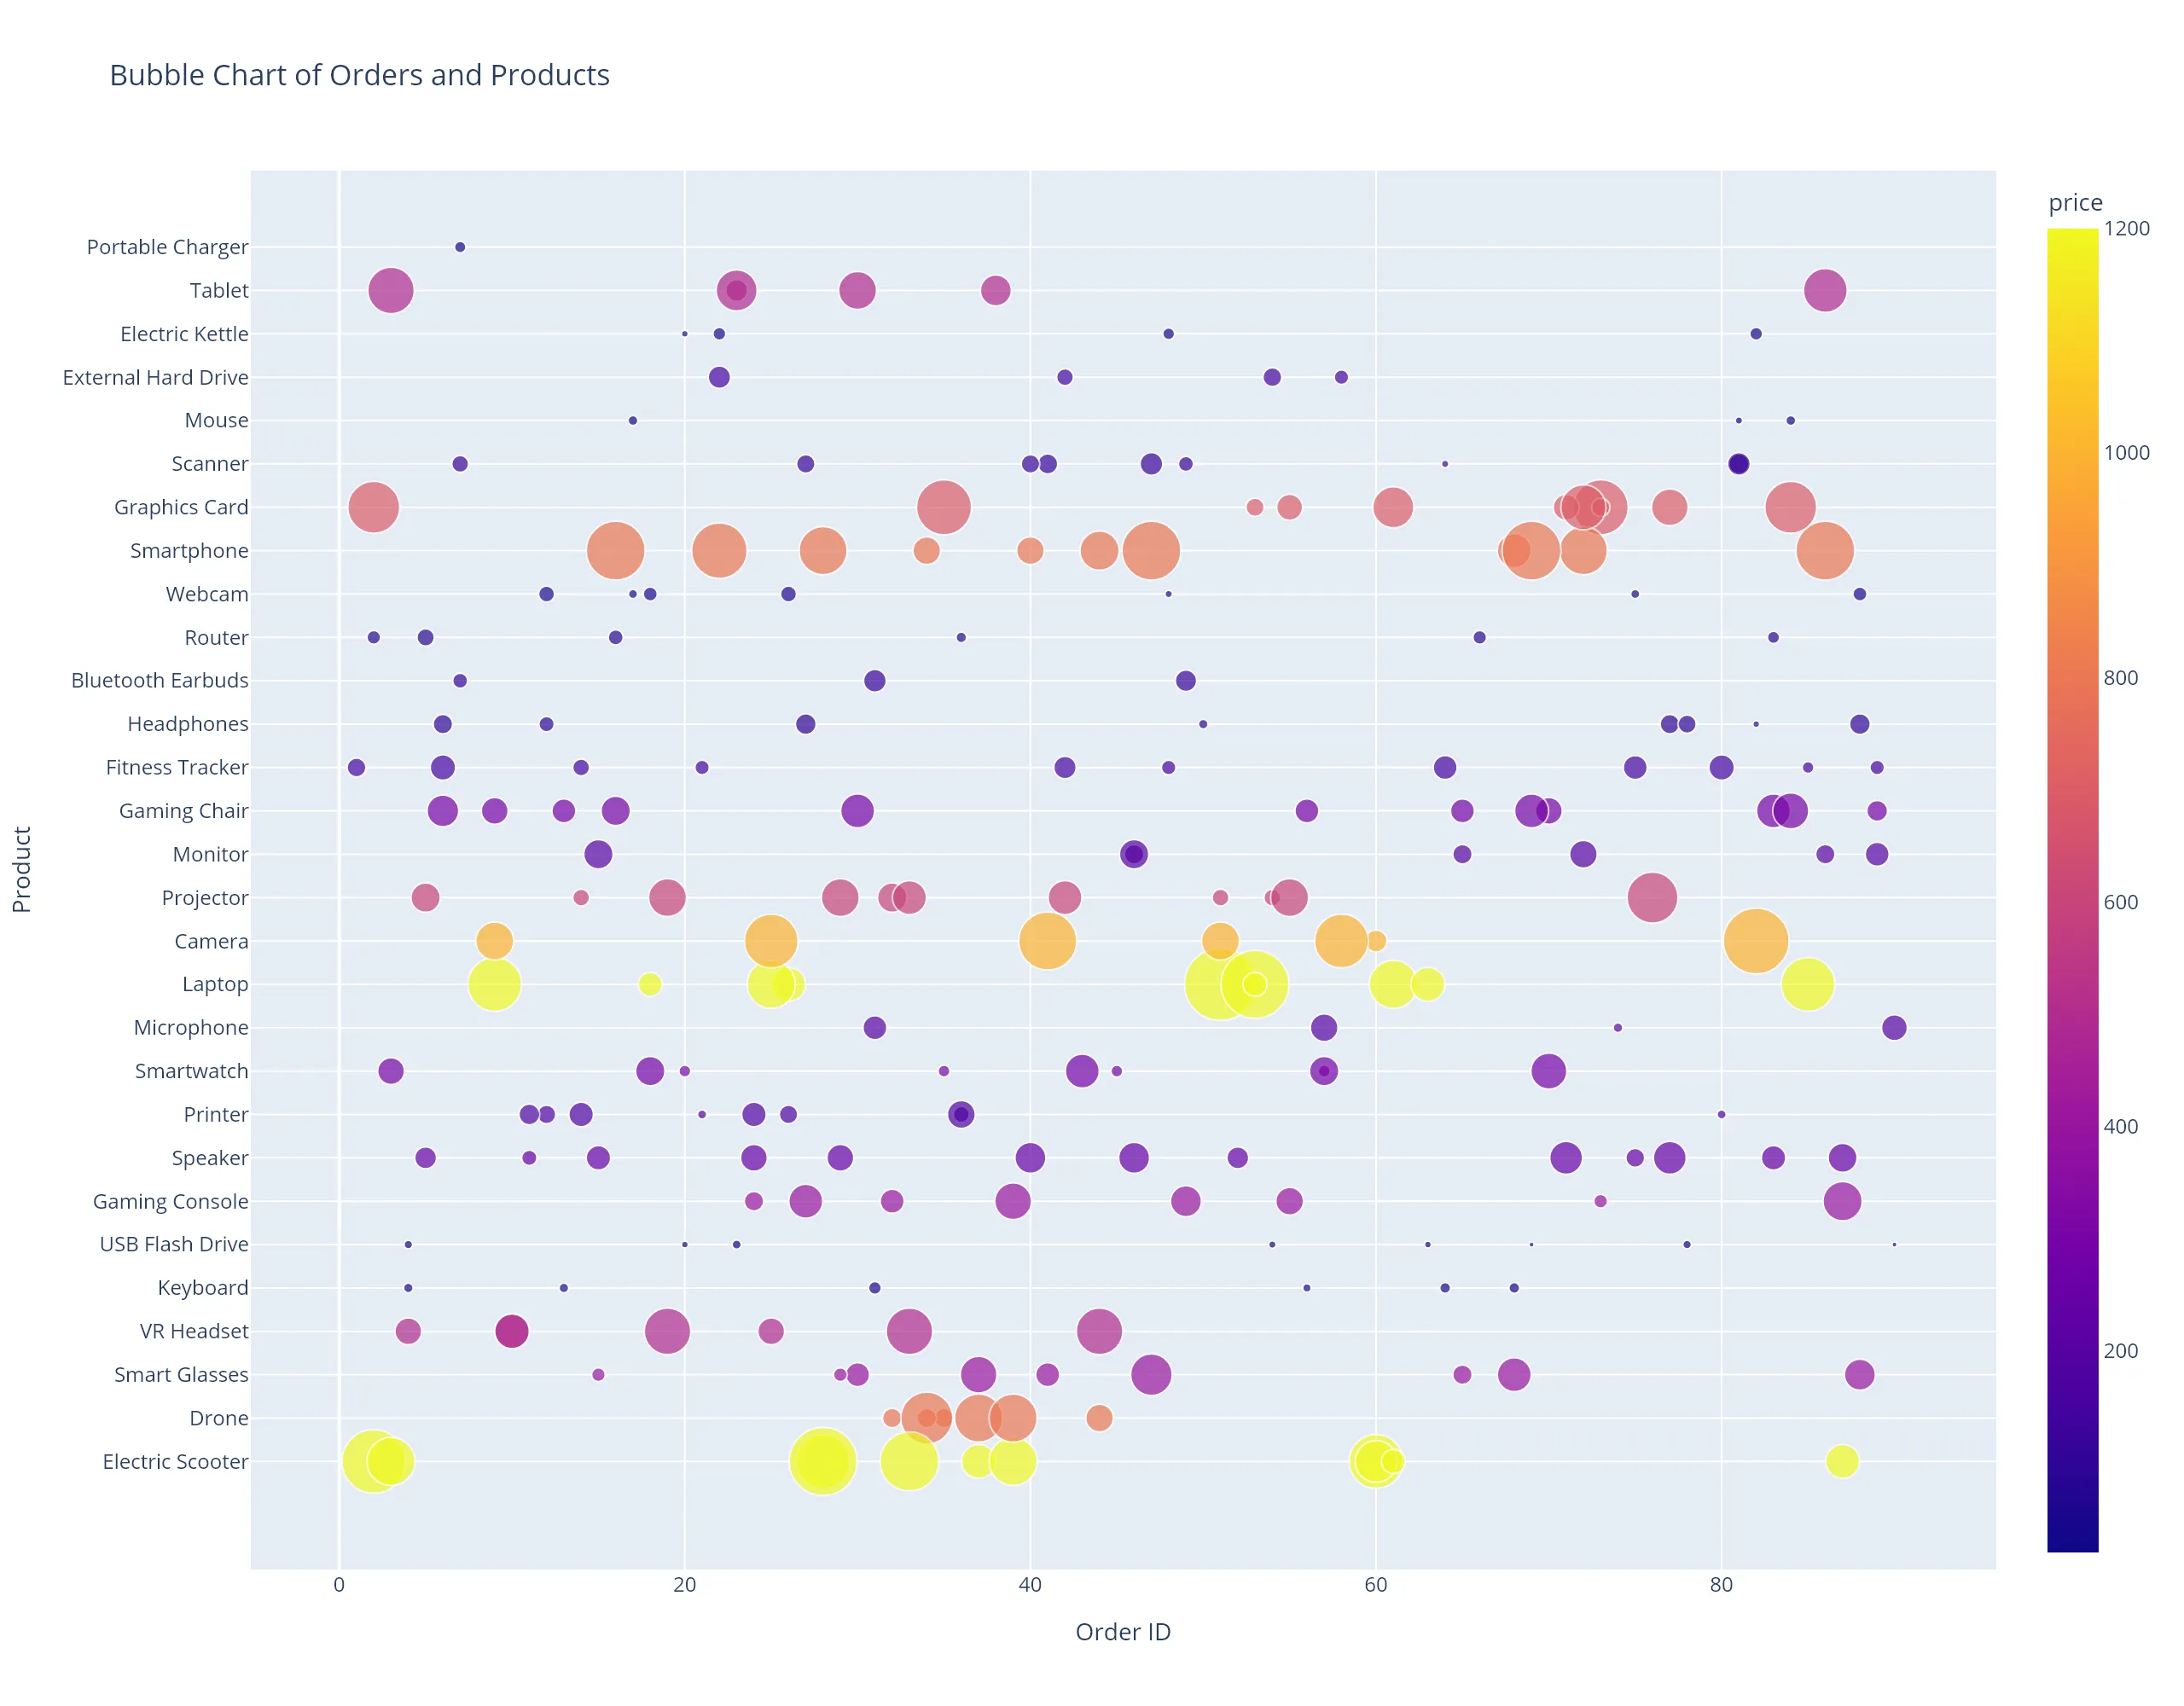

In [45]:
# Create a bubble chart using Plotly
fig = px.scatter(
    expanded_df,
    x="order_id",               # X-axis: Order ID
    y="product_name",           # Y-axis: Product name
    size="total_price",         # Size of bubbles: Total Price (can change to 'quantity' or 'price')
    color="price",              # Color of bubbles: Price
    hover_name="product_name",  # Hover information: Product name
    hover_data=["price", "quantity", "total_price"],  # Additional hover data
    title="Bubble Chart of Orders and Products",
    labels={"order_id": "Order ID", "product_name": "Product", "total_price": "Total Price"},
    size_max=30,                 # Maximum size of bubbles
    height=1000
)

# Show the plot
# show_plot(fig, interactive=True) # Make interactive to see the order_id and details for each bubble
show_plot(fig)

**Key Findings and Insights**

1. **Diversity in Product Categories**:
   - The dataset reveals a wide range of consumer electronics and accessories sold, including high-end items such as laptops, smartphones, projectors, and gaming consoles, as well as more affordable accessories like keyboards, speakers, and USB flash drives.
   
2. **Top 3 Most Expensive Products per Order**:
   - For each order, the highest-priced products tend to be large-ticket items like **laptops**, **smartphones**, and **gaming consoles**. For example:
     - Order ID 37: Electric Scooter, Drone, and Smart Glasses.
     - Order ID 4: VR Headset, Keyboard, and USB Flash Drive.
     - Order ID 51: Laptop, Camera, and Projector.
     - Order ID 2: Electric Scooter, Graphics Card, and Router.

3. **Frequent High-value Items**:
   - **Smartphones** and **Laptops** appear consistently across multiple orders as the top expensive items, with prices ranging from $800 to $1200.
   - **Gaming Consoles** and **Projectors** also appear frequently as premium products in various orders, demonstrating their strong market demand.
   
4. **Price Distribution**:
   - The highest individual-priced items are generally in the $1000 - $1200 range (e.g., **Laptop** and **Electric Scooter**), while lower-priced products (e.g., **USB Flash Drives**, **Keyboards**, and **Headphones**) are consistently part of the order, but with much lower prices (ranging from $20 to $150).
   
5. **Concentration of Purchases**:
   - Orders with multiple items often contain a blend of higher-priced and more affordable products, highlighting consumers' tendency to mix premium products with lower-cost accessories.

**Insights for Action**

- **Focus on High-value Products**: Products like **laptops**, **smartphones**, and **gaming consoles** should be prioritized in marketing campaigns and inventory stocking, as they consistently drive higher sales volumes and total revenue per order.
  
- **Cross-Selling Opportunities**: Many orders feature both high-value items and low-cost accessories, suggesting a potential strategy for bundling products or recommending related accessories (e.g., suggesting a **keyboard** with a **laptop** or **headphones** with a **gaming console**).

- **Customer Segmentation**: Grouping customers based on their tendency to purchase higher-end vs. budget-friendly products can help tailor personalized offers, discounts, and promotions to increase customer retention and maximize order value.

In [52]:
pipeline = [
    {"$lookup": {

        "from": "order_items",

        "localField": "order_id",

        "foreignField": "order_id",

        "as": "order_details"

    }},

    {"$unwind": "$order_details"},

    {"$group": {

        "_id": "$order_details.product_id",

        "total_revenue": {"$sum": {"$multiply": ["$order_details.quantity", "$order_details.price"]}}

    }},
    {
        "$project": {
            "product_id": "$_id",
            "total_revenue": 1,
            "_id": 0
        }
    },
    {"$sort": {"total_revenue": -1}}

]

cursor = orders.aggregate(pipeline)

result = cursor.to_list()

In [54]:
df = (pd.DataFrame(result, columns=["product_id", "total_revenue"]))
df.head()

,product_id,total_revenue
0,125,159416
1,121,151435
2,126,145941
3,118,125934
4,119,125013


**Key Findings and Insights**

1. **Top-Performing Products:**
   - The top 3 products generating the highest total revenue are:
     - Product ID 125: $159,416 in revenue
     - Product ID 121: $151,435 in revenue
     - Product ID 126: $145,941 in revenue
   - These products lead by significant margins, and their total revenues are markedly higher than the subsequent products in the list.

2. **Revenue Distribution:**
   - The distribution of total revenue among products shows a sharp decline after the top 3. While the leading products earn revenues close to or exceeding $150,000, the next few products fall below $125,000.
   - The revenue graph suggests a heavy concentration of earnings in a few products, indicating the potential for focused marketing and promotion strategies on high-performing items.

3. **Potential Growth Opportunities:**
   - Several products, such as Product ID 116 and Product ID 106, show comparatively lower revenues, under $50,000, suggesting that they may either have lower sales volumes, higher competition, or less consumer interest.
   - There could be an opportunity to investigate these products further to identify potential issues or optimize their pricing, positioning, or promotion.

4. **Actionable Strategy:**
   - Focus on the top-performing products for cross-selling and bundling strategies.
   - Investigate the underperforming products to identify any gaps in product offerings, customer targeting, or competitive pricing that may be limiting their revenue potential.
   - Continuously monitor revenue data to track changes in product performance and make timely adjustments.


### Task 3: Schema Design and Optimization
**4.3.1 Choose between embedded and referenced schema designs for each collection and explain why.**
- Create indexes on frequently queried fields like customer_id and product_id.

Index Example:

db.orders.create_index([(“customer_id”, 1)]

#### 4.3.1.1. Customers Collection
**Design:** Embedded

- The `customers` collection contains basic customer information such as name, email, and address. This data is relatively self-contained, and each customer is unlikely to change often, making it a good candidate for an embedded schema.
- The `address` field is an object, which is embedded within the customer document.
- The customer’s information doesn’t need to reference other documents frequently, so embedding the address data directly in the customer document is more efficient.

**Reasoning**:
- **Efficiency**: Storing the customer’s address directly within the customer document eliminates the need for a join when querying for a customer’s details and address.
- **Atomicity**: By embedding all the customer data in one document, updates to customer data are easier to manage atomically.

**Sample**:
```json
{
  "_id": ObjectId("..."),
  "customer_id": 1,
  "name": "Alice",
  "email": "alice@example.com",
  "address": {
    "street": "123 Maple Street",
    "city": "Springfield",
    "state": "IL"
  }
}
```

#### 4.3.1.2. Products Collection

**Design**: Referenced

- The `products` collection stores product details such as `product_id`, `product_name`, `category`, and `price`. This data is likely to be reused across multiple orders, so it is better to reference products rather than embedding them within each order.
- Products are shared across orders, and product details like `price` or `category` might change over time. By storing product data separately, any changes to product information can be easily managed.

**Reasoning**:
- **Reuse**: Products are used in multiple orders, and referencing them avoids unnecessary duplication of product data across multiple order items.
- **Data Consistency**: If product details (e.g., price or category) need to change, it is more efficient to update the product document once rather than updating it in every order item.

**Sample**:
```json
{
  "_id": ObjectId("..."),
  "product_id": 101,
  "product_name": "Laptop",
  "category": "Electronics",
  "price": 1200
}
```

#### 3. Orders Collection

**Design**: Referenced

- The `orders` collection stores details about an order, including a reference to the `customer_id` (who placed the order), `order_date`, and `status`.
- Since orders can have many items, the `orders` collection should reference other collections (e.g., `customer_id`, `order_items`) rather than embedding order items directly.

**Reasoning**:
- **Separation of Concerns**: Orders are independent entities that need to track the customer who placed the order. Embedding the entire order items directly into the order would result in large documents that are difficult to manage.
- **Scalability**: Orders might have a large number of items, and embedding all these items within the order document could result in inefficient queries and increased document size. Instead, we reference `order_items` to keep the order document lightweight.

**Sample**:
```json
{
  "_id": ObjectId("..."),
  "order_id": 5001,
  "customer_id": 1,
  "order_date": "2024-01-15T10:00:00Z",
  "status": "Delivered"
}
```

#### 4. Order Items Collection

**Design**: Referenced

- The `order_items` collection stores the individual items in an order, referencing both the `order_id` (to associate items with orders) and `product_id` (to link items to products). This is a classic example of a referenced schema.
- Storing individual items as separate documents in the `order_items` collection is efficient for querying and avoids duplication of product data across orders.

**Reasoning**:
- **Efficient Querying**: By referencing `product_id`, you can easily query the details of products associated with an order item without duplicating product data in every order.
- **Flexibility**: You can add, update, or remove items from an order without needing to modify the main order document, providing more flexibility for managing orders.

**Example**:
```json
{
  "_id": ObjectId("..."),
  "order_item_id": 9001,
  "order_id": 5001,
  "product_id": 101,
  "quantity": 2,
  "price": 1200
}
```



### **Indexes**

For optimization, indexes should be created on frequently queried fields to improve query performance, especially for fields used in `find`, `update`, and `aggregate` operations. Below are the recommended indexes for each collection:

#### 1. Customers Collection
- **Index on `customer_id`** for fast lookups when querying customer data.
- **Index on `email`** for quick lookups by email address (if necessary).

#### 2. Products Collection
- **Index on `product_id`** for fast lookups when querying product data.
- **Index on `category`** if querying products by category is frequent.

#### 3. Orders Collection
- **Index on `customer_id`** to quickly fetch all orders for a specific customer.
- **Index on `order_id`** to ensure fast lookups for specific orders.
- **Index on `status`** if filtering orders by status is common.

#### 4. Order Items Collection
- **Index on `order_id`** to quickly fetch all items in an order.
- **Index on `product_id`** for fast lookups of products in order items.
- **Compound index on `order_id` and `product_id`** to improve performance when querying items by both order and product.

In [ ]:
db.customers.create_index([("customer_id", 1)], unique=True)
db.customers.create_index([("email", 1)], unique=True)

db.products.create_index([("product_id", 1)], unique=True)
db.products.create_index([("category", 1)])

db.orders.create_index([("customer_id", 1)])
db.orders.create_index([("order_id", 1)], unique=True)
db.orders.create_index([("status", 1)])

db.order_items.create_index([("order_id", 1)])
db.order_items.create_index([("product_id", 1)])
db.order_items.create_index([("order_id", 1), ("product_id", 1)])

### **Schema Design Summary**

- **Customers**: **Embedded schema** for address data, as it is part of the customer’s profile and not expected to change frequently.
- **Products**: **Referenced schema** for efficient reuse across multiple orders.
- **Orders**: **Referenced schema** to separate order details and items, allowing flexibility and scalability.
- **Order Items**: **Referenced schema** to manage each item in an order independently, linked to both orders and products.

### Task 4: Advanced Features
**4.4.1 Implement Transactions:**
- Simulate an order creation process that updates the orders and inventory collections atomically.

MongoDB transactions ensure that multiple operations are executed atomically, meaning either all operations succeed or none are applied. Transactions are supported in replica sets and sharded clusters in MongoDB 4.0+.

I will simulate the order creation process where:
- A new order is created in the `orders` collection.
- The inventory (in the `products` collection) is updated to reflect the reduction in quantity based on the order items.


In [154]:
def generate_id_from_field(collection: Collection, field: str) -> Optional[int]:
    """
    Generates a new ID by finding the maximum value of a specified field in a MongoDB collection.
    This is useful for auto-generating a new ID based on the current highest value of a particular field, 
    such as for creating a new order ID or product ID.

    Args:
        collection (Collection): The MongoDB collection to query for the field.
        field (str): The field name whose maximum value will be used to generate the new ID.

    Returns:
        Optional[int]: The new ID (one more than the current maximum value). Returns None if no results are found.
    """
    # Aggregation pipeline to find the maximum value of the specified field
    pipeline = [
        {
            "$group": {
                "_id": None,  # Grouping by null to get a single result
                f"max_{field}": { "$max": f"${field}" }  # Find the maximum value of the specified field
            }
        }
    ]

    # Execute the aggregation pipeline on the collection
    result = collection.aggregate(pipeline)

    # Fetch and print the result (Get the first (and only) result from the aggregation)
    max_id = next(result, None)
    
    _id = None  # Default to None in case no result is returned
    if max_id:
        # Extract the maximum value from the result and increment it by 1
        _id = max_id.get(list(max_id)[1]) + 1  # Example: {'_id': None, 'max_order_id': 90} -> _id = 91
    
    # Return the generated ID or None if no result was found
    return _id


In [178]:

# Define the order creation process
def create_order(customer_id: int, product_orders: List[Dict[str, int]]) -> None:
    """
    Create a new order and update the inventory atomically.

    This function begins a MongoDB transaction where the following steps are performed:
    1. Insert a new order into the orders collection.
    2. Insert the corresponding order items into the order_items collection.
    3. Update the inventory by reducing the stock of each product based on the ordered quantity.

    Args:
    customer_id (int): The ID of the customer placing the order.
    product_orders (List[Dict[str, int]]): A list of dictionaries containing product details:
        - 'product_id': The ID of the product being ordered.
        - 'quantity': The quantity of the product being ordered.
        - 'price': The price of the product.

    Returns:
    None: This function does not return any value, but prints the result or an error message.
    """
    
    # Start a session for transaction
    with client.start_session() as session:
        with session.start_transaction():  # Begin transaction

            try:
                # Insert the order document
                order_id = generate_id_from_field(orders, "order_id") # New order id
                
                order = {
                    "order_id": order_id,
                    "customer_id": customer_id,
                    "order_date": dt.datetime.strptime("2024-12-22T10:00:00Z", "%Y-%m-%dT%H:%M:%SZ"),  # Convert string to datetime,
                    "status": "Processing"
                }
                orders.insert_one(order, session=session)

                # Insert order items and update inventory for each product ordered
                for product in product_orders:
                    product_id = product['product_id']
                    quantity = product['quantity']

                    # Insert order item document
                    order_item = {
                        "order_item_id": generate_id_from_field(order_items, "order_item_id"),
                        "order_id": order_id,
                        "product_id": product_id,
                        "quantity": quantity,
                        "price": product['price']
                    }
                    order_items.insert_one(order_item, session=session)

                    # # Update the product inventory (reduce stock)
                    # product_update = {
                    #     "$inc": {"stock": -quantity}  # Decrease stock by the ordered quantity
                    # }
                    # products.update_one({"product_id": product_id}, product_update, session=session)

                # Commit the transaction to apply changes
                session.commit_transaction()
                print(f"Order {order_id} created successfully.")

            except Exception as e:
                # Abort transaction in case of an error
                session.abort_transaction()
                print(f"Oops, an error occurred: {e}")


# Example usage of create_order function
# Uncomment the following lines to create an order:
# create_order(9999, [
#     {"product_id": 9999, "quantity": 2, "price": 1200},
#     {"product_id": 9999, "quantity": 1, "price": 800}
# ])


In [ ]:
# Find a customer
customer_id = customers.find_one()['customer_id']

# Generate new product ids
new_product_id = generate_id_from_field(products, "product_id")
new_product_id_2 = new_product_id + 1


# Create order
create_order(customer_id, [
    {"product_id": new_product_id, "quantity": 2, "price": 1200},
    {"product_id": new_product_id_2, "quantity": 1, "price": 800}
])



**4.4.2 Use Change Streams:**
- Monitor real-time changes in the orders collection.


### **2. Using Change Streams**

Change Streams in MongoDB allow you to listen for real-time changes to documents in collections. We can monitor the `orders` collection for changes (insertions, updates, deletions) in real time.


In [188]:
# Define a function to watch for changes in the orders collection
def watch_orders():
    try:
        # Start the change stream on the 'orders' collection
        with orders.watch() as stream:
            for change in stream:
                print("Change detected:", change)
    except ConnectionFailure as e:
        print("Error connecting to MongoDB:", e)
    except Exception as e:
        print("An error occurred:", e)

In [ ]:
# Start watching changes in the orders collection
watch_orders()

**PS:**
1. **watch()**: This method opens a change stream on the collection.
2. **Real-time monitoring**: The `for` loop continuously listens for changes in the collection and prints them when detected.
3. **Types of changes detected**: The stream can detect `insert`, `update`, `delete`, and other operations performed on the collection.



**4.4.3 Apply Schema Validation:**
- Ensure all documents in the products collection include a valid price.

To ensure data integrity in the `products` collection, we can apply a schema validation rule to ensure that all documents include a valid `price` field (greater than 0).

In [192]:
# Check if documents match expected types and structure
valid_documents = []
invalid_documents = []

for doc in products.find():
    if isinstance(doc.get("price"), (float, int)):
        valid_documents.append(doc)
        print(f"Valid document: {doc}")
    else:
        invalid_documents.append(doc)
        print(f"Invalid document: {doc}")

Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c301'), 'product_id': 101, 'product_name': 'Laptop', 'category': 'Electronics', 'price': 1200}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c302'), 'product_id': 102, 'product_name': 'Smartphone', 'category': 'Electronics', 'price': 800}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c303'), 'product_id': 103, 'product_name': 'Tablet', 'category': 'Electronics', 'price': 500}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c304'), 'product_id': 104, 'product_name': 'Smartwatch', 'category': 'Wearable Technology', 'price': 300}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c305'), 'product_id': 105, 'product_name': 'Gaming Console', 'category': 'Electronics', 'price': 400}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c306'), 'product_id': 106, 'product_name': 'External Hard Drive', 'category': 'Storage', 'price': 150}
Valid document: {'_id': ObjectId('67669fd1fc13ae5281e1c307'), 'product_id': 10

In [196]:
print(f"There are {len(valid_documents)} valid documents and {len(invalid_documents)} invalid documents.")

There are 29 valid documents and 0 invalid documents.


### NB
If the collection already exists and needs to be revalidated, the new validation can be applied using:
```python

product_validation = {
    "$jsonSchema": {
        "bsonType": "object",
        "required": ["product_id", "product_name", "category", "price"],
        "properties": {
            "_id": {
                "bsonType": "objectId"
            },
            "product_id": {
                "bsonType": "int",
                "description": "must be an integer"
            },
            "product_name": {
                "bsonType": "string",
                "minLength": 1,
                "description": "must be a non-empty string"
            },
            "category": {
                "bsonType": "string",
                "minLength": 1,
                "description": "must be a non-empty string"
            },
            "price": {
                "bsonType": "int",
                "minimum": 0,
                "description": "must be a positive number"
            }
        }
    }
}

db.command({
    "collMod": "products",
    "validator": product_validation
})
```

Made with 💖 [Gabriel Okundaye](https://www.linkedin.com/in/dr-gabriel-okundaye)
<span style="color: #aaaaaa;">& Light ✨</span>